In [1]:
import sys, os, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn')
from sklearn.metrics import classification_report, confusion_matrix                  

import tensorflow as tf
print('Using TENSORFLOW version :----->', tf.__version__)
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Dropout)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

seed = 123
random.seed(seed)
np.random.seed(seed)
#tf.set_random_seed(seed)

import warnings
warnings.filterwarnings('ignore')  


import cv2
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import imageio
import skimage
import skimage.io
import skimage.transform


import itertools
import shutil

Using TENSORFLOW version :-----> 2.4.1


In [3]:
images_root = "DATA/2538"                               
train_root = os.path.join(images_root,'train')            
eval_root = os.path.join(images_root,'eval')               
test_root = os.path.join(images_root,'test')               

IMAGE_HEIGHT = 224
IMAGE_WIDTH  = 224
IMAGE_CHANNEL = 3
BATCH_SIZE = 8
EPOCH_N = 200

In [10]:
#ARCH ANALYSIS

In [4]:
VGG_16_ARCH = tf.keras.applications.vgg16.VGG16()
from tensorflow.keras.models import Sequential

VGG_16_SEQ_ARCH = Sequential()
for layer in VGG_16_ARCH.layers:
    VGG_16_SEQ_ARCH.add(layer)
    
#VGG_16_SEQ_ARCH.summary() 

In [6]:
VGG_16_SEQ_ARCH.pop()   
#VGG_16_SEQ_ARCH.summary()

In [7]:
for layer in VGG_16_SEQ_ARCH.layers:
    layer.trainable = False
    
    
VGG_16_SEQ_ARCH.add(Dense(2, activation='softmax'))  

#VGG_16_SEQ_ARCH.summary()

In [8]:
from tensorflow.keras.applications import VGG16                             
VGG_BASE_1 = VGG16(weights='imagenet',    
                 include_top=False,     
                 input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNEL))
VGG_BASE_2 = VGG16(weights='imagenet', include_top=False, input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNEL))

def build_model_1():                            
    MODEL_1 = tf.keras.models.Sequential([
        VGG_BASE_1,                               
        Flatten(),                               
        Dropout(0.50),
        Dense(1024, activation='relu'),
        Dropout(0.20),        
        Dense(512, activation='relu'),
        Dropout(0.10),         
        Dense(1, activation='sigmoid')    
    ])
       
    VGG_BASE_1.trainable = False  
    
    MODEL_1.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    return MODEL_1


def build_model_2():                            
    MODEL_2 = tf.keras.models.Sequential([        
        VGG_BASE_2,                                      
        Flatten(),                                
        Dropout(0.50),
        Dense(1024, activation='relu'),
        Dropout(0.20),        
        Dense(512, activation='relu'),
        Dropout(0.10),         
        Dense(1, activation='sigmoid')    
    ])
    
       
    trainable = False
    for layer in VGG_BASE_2.layers:
       if layer.name == 'block5_conv2':
           trainable = True 
       layer.trainable = trainable
    
    MODEL_2.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    return MODEL_2

MODEL_1 = build_model_1()
MODEL_2 = build_model_2()
#print(VGG_BASE_1.summary())              
#print(VGG_BASE_2.summary())              
#print(MODEL_1.summary())
#print(MODEL_2.summary())

In [9]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

eval_datagen = ImageDataGenerator(rescale=1.0/255)            
test_datagen = ImageDataGenerator(rescale=1.0/255)


train_generator = train_datagen.flow_from_directory(
    train_root,
    target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),  
    batch_size=BATCH_SIZE,
    class_mode='binary')

eval_generator = eval_datagen.flow_from_directory(eval_root,target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),batch_size=BATCH_SIZE,class_mode='binary')
test_generator = test_datagen.flow_from_directory(test_root,target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),batch_size=BATCH_SIZE,class_mode='binary', shuffle=False)


train_steps = train_generator.n // BATCH_SIZE
val_steps = eval_generator.n // BATCH_SIZE
test_steps = test_generator.n // BATCH_SIZE
print('LEARNING_STEPS :--------> train_steps =', train_steps, ' |val_steps =', val_steps, ' |test_steps =', test_steps)


Found 1974 images belonging to 2 classes.
Found 563 images belonging to 2 classes.
Found 208 images belonging to 2 classes.
LEARNING_STEPS :--------> train_steps = 246  |val_steps = 70  |test_steps = 26


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau


checkpoint_callback = ModelCheckpoint(filepath='ENGINE_WEIGHTS/ENGINE.{epoch:02d}-{val_loss:.2f}.h5', save_weights_only=False, monitor='val_acc', mode='max', save_best_only=False, period=1, verbose=1)


reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=2, verbose=1, mode='max', min_lr=0.00001)

HISTORY_STATS = MODEL_2.fit_generator(train_generator, steps_per_epoch=train_steps, epochs=EPOCH_N, validation_data=eval_generator, validation_steps=val_steps, callbacks=[checkpoint_callback, reduce_lr])


Epoch 1/200
246/246 [==============================] - 788s 3s/step - loss: 0.4645 - accuracy: 0.7645 - val_loss: 0.1701 - val_accuracy: 0.9375

Epoch 00001: saving model to ENGINE_WEIGHTS\ENGINE.01-0.17.h5
Epoch 2/200
246/246 [==============================] - 805s 3s/step - loss: 0.2621 - accuracy: 0.8781 - val_loss: 0.1457 - val_accuracy: 0.9339

Epoch 00002: saving model to ENGINE_WEIGHTS\ENGINE.02-0.15.h5
Epoch 3/200
246/246 [==============================] - 804s 3s/step - loss: 0.2282 - accuracy: 0.9029 - val_loss: 0.0560 - val_accuracy: 0.9786

Epoch 00003: saving model to ENGINE_WEIGHTS\ENGINE.03-0.06.h5
Epoch 4/200
246/246 [==============================] - 798s 3s/step - loss: 0.1681 - accuracy: 0.9276 - val_loss: 0.0387 - val_accuracy: 0.9750

Epoch 00004: saving model to ENGINE_WEIGHTS\ENGINE.04-0.04.h5
Epoch 5/200
246/246 [==============================] - 794s 3s/step - loss: 0.1992 - accuracy: 0.9087 - val_loss: 0.0416 - val_accuracy: 0.9839

Epoch 00005: saving model t

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


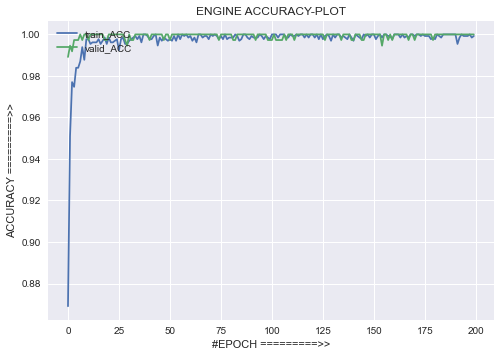

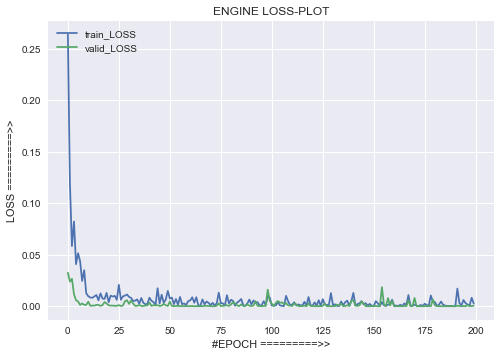

In [9]:
#MODEL_1.fit_generator(train_generator, steps_per_epoch=train_steps, epochs=EPOCH_N, validation_data=eval_generator, validation_steps=val_steps)

# OR

#HISTORY_STATS = MODEL_2.fit_generator(train_generator, steps_per_epoch=train_steps, epochs=EPOCH_N, validation_data=eval_generator, validation_steps=val_steps)


print(HISTORY_STATS.history.keys())


plt.plot(HISTORY_STATS.history['accuracy'])
plt.plot(HISTORY_STATS.history['val_accuracy'])
plt.title('ENGINE ACCURACY-PLOT')
plt.ylabel('ACCURACY =========>>')
plt.xlabel('#EPOCH =========>>')
plt.legend(['train_ACC', 'valid_ACC'], loc='upper left')
plt.show()


plt.plot(HISTORY_STATS.history['loss'])
plt.plot(HISTORY_STATS.history['val_loss'])
plt.title('ENGINE LOSS-PLOT')
plt.ylabel('LOSS =========>>')
plt.xlabel('#EPOCH =========>>')
plt.legend(['train_LOSS', 'valid_LOSS'], loc='upper left')
plt.show()
#plt.savefig('LossVal_loss.png')

In [10]:
#model = MODEL_1                         
# OR
model = MODEL_2

loss, acc = model.evaluate_generator(train_generator, steps=train_steps, verbose=1)
print('TRAINING DATA LOSS & ACC.  ------------> loss: %.3f, acc: %.3f' % (loss, acc))
loss, acc = model.evaluate_generator(eval_generator, steps=val_steps, verbose=1)
print('VALDIATION DATA LOSS & ACC. -----------> loss: %.3f, acc: %.3f' % (loss, acc))
loss, acc = model.evaluate_generator(test_generator, steps=test_steps, verbose=1)
print('TESTING DATA LOSS & ACC.   ------------> loss: %.3f, acc: %.3f' % (loss, acc))

model.save('ENGINE_W1.h5')

164/164 [==============================] - 357s 2s/step - loss: 2.3100e-04 - accuracy: 1.0000
TRAINING DATA LOSS & ACC.  ------------> loss: 0.000, acc: 1.000
46/46 [==============================] - 98s 2s/step - loss: 4.7683e-04 - accuracy: 1.0000
VALDIATION DATA LOSS & ACC. -----------> loss: 0.000, acc: 1.000
23/23 [==============================] - 47s 2s/step - loss: 0.0176 - accuracy: 0.9946
TESTING DATA LOSS & ACC.   ------------> loss: 0.018, acc: 0.995


In [14]:
PREDICTION = model.predict_generator(test_generator, steps=test_steps, verbose=1)
PREDICTION = np.round(PREDICTION[:,0])
print("PREDICTION_VALUES :------->", PREDICTION)                            
REAL_LABELS = test_generator.classes
print("REAL_CLASSES_VALUES :----->", REAL_LABELS)                           
print("---------------------------------------------------------EVALUATION-------------------------------------------------------------")
print("----------------------------------------------------CLASSIFICATION REPORT-------------------------------------------------------")

CLASS_NAMES = ['CXR', 'NON_CXR']
print(classification_report(REAL_LABELS, PREDICTION, target_names=CLASS_NAMES))
print("")     

cm = confusion_matrix(REAL_LABELS, PREDICTION) 
print('--------------------------CONFUSION MATRIX using Scikit-learn---------------------------------')  
print(cm)
print('----------------------------------------------------------------------------------------------')
print("")


import itertools
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("PLOT - Normalized confusion matrix")
    else:
        print('PLOT - Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


CLASS_1_name = 'CXR'
CLASS_2_name = 'NON_CXR'
cm_plot_labels = [CLASS_1_name, CLASS_2_name]
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='CONFUSION MATRIX') 


 7/23 [========>.....................] - ETA: 28s

UnknownError:  FileNotFoundError: [Errno 2] No such file or directory: 'DATA/1880\\test\\CXR\\STDWfrhS1596530706_1.png'
Traceback (most recent call last):

  File "c:\users\hp\anaconda3\envs\project\lib\site-packages\tensorflow\python\ops\script_ops.py", line 249, in __call__
    ret = func(*args)

  File "c:\users\hp\anaconda3\envs\project\lib\site-packages\tensorflow\python\autograph\impl\api.py", line 620, in wrapper
    return func(*args, **kwargs)

  File "c:\users\hp\anaconda3\envs\project\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py", line 891, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "c:\users\hp\anaconda3\envs\project\lib\site-packages\tensorflow\python\keras\engine\data_adapter.py", line 807, in wrapped_generator
    for data in generator_fn():

  File "c:\users\hp\anaconda3\envs\project\lib\site-packages\tensorflow\python\keras\engine\data_adapter.py", line 933, in generator_fn
    yield x[i]

  File "c:\users\hp\anaconda3\envs\project\lib\site-packages\keras_preprocessing\image\iterator.py", line 65, in __getitem__
    return self._get_batches_of_transformed_samples(index_array)

  File "c:\users\hp\anaconda3\envs\project\lib\site-packages\keras_preprocessing\image\iterator.py", line 230, in _get_batches_of_transformed_samples
    interpolation=self.interpolation)

  File "c:\users\hp\anaconda3\envs\project\lib\site-packages\keras_preprocessing\image\utils.py", line 113, in load_img
    with open(path, 'rb') as f:

FileNotFoundError: [Errno 2] No such file or directory: 'DATA/1880\\test\\CXR\\STDWfrhS1596530706_1.png'


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]] [Op:__inference_predict_function_117588]

Function call stack:
predict_function


In [12]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr1, tpr1, thresh1 = roc_curve(REAL_LABELS, PREDICTION)
print("FPR :-------->", fpr1)
print("TPR :-------->", tpr1)
print("Threhold :--->", thresh1)
print("")
auc_score1 = roc_auc_score(REAL_LABELS, PREDICTION)                 
print("AUC_SCORE: ", auc_score1)
print("--------------------------------------------------------------------------------------------------------------------")


import matplotlib.pyplot as plt
plt.style.use('seaborn')
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr1, tpr1, linestyle='--',color='orange', label='Binary_CLASSIFIER (area = {:.3f})'.format(auc_score1))  # plot roc curves
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();


plt.figure(2)
plt.xlim(0, 0.6)   
plt.ylim(0.8, 1)   
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr1, tpr1, linestyle='--', color='orange', label='Binary_CLASSIFIER (area = {:.3f})'.format(auc_score1))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()


NameError: name 'REAL_LABELS' is not defined